<a href="https://colab.research.google.com/github/CheshireCat12/Deep_learning_challenges/blob/master/CAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.autograd import Variable
from torch.utils.data import DataLoader

In [0]:
DOWNLOAD_DATASET = False
BATCH_SIZE = 64
NB_TEST_IMG = 5
NB_EPOCHS = 50
DEVICE= torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
norm_mean = [0.1307]
norm_std = [0.3081]

pre_process = transforms.Compose([transforms.ToTensor(),
                                  transforms.Normalize(
                                    mean=norm_mean,
                                    std=norm_std)])

train_data = datasets.MNIST(root='./data',
                            train=True,
                            transform=pre_process,
                            download=True)
 
train_loader = DataLoader(train_data,
                          batch_size=BATCH_SIZE,
                          shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 21716264.04it/s]                            


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 294803.69it/s]                           
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 5416404.31it/s]                           
8192it [00:00, 124012.38it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [0]:
class ConvolutionAutoEncoder(nn.Module):
    
    def __init__(self):
        super(ConvolutionAutoEncoder, self).__init__()
        
        # (n + 2p - f)/s + 1
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3), # 8, 26, 26
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3), # 16, 24, 24
            nn.ReLU(),
            nn.Conv2d(16, 8, kernel_size=3), # 8, 10, 10
            nn.ReLU(),
        )
        
        # s(n-1)+f-2p
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, kernel_size=3), # 16, 9, 9
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=3), # 16, 17, 17
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, kernel_size=3), # 1, 28, 28
            nn.Sigmoid()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        #print(encoded.size())
        decoded = self.decoder(encoded)
        
        return encoded, decoded

In [24]:
CAE = ConvolutionAutoEncoder()
CAE.to(DEVICE)
print(CAE)

optimizer_cae = torch.optim.Adam(CAE.parameters(), weight_decay=1e-5)
# optimizer_cae = torch.optim.SGD(CAE.parameters(), lr=0.02, momentum=0.85)
loss_func_cae = nn.MSELoss()

view_data_cae = Variable(train_data.data[:NB_TEST_IMG].view(-1, 1, 28, 28).type(torch.cuda.FloatTensor))

ConvolutionAutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(1, 1))
    (5): Sigmoid()
  )
)


In [0]:
def plot_img(model, view_data):
    _, decoded_data = model(view_data)  
    
    f, a = plt.subplots(2, NB_TEST_IMG, figsize=(10, 4))
    
    for i in range(NB_TEST_IMG):
        a[0][i].imshow(np.reshape(view_data.cpu().data.numpy()[i],
                                   (28, 28)),
                                   cmap='gray')
        a[0][i].set_xticks(())
        a[0][i].set_yticks(())
    
        
    for i in range(NB_TEST_IMG):
        a[1][i].imshow(np.reshape(decoded_data.cpu().data.numpy()[i],
                                   (28, 28)),
                                   cmap='gray')
        a[1][i].set_xticks(())
        a[1][i].set_yticks(())

    plt.show()
    

def trainCAE(model, data_loader, view_data, loss_func, optimizer):
    for epoch in range(NB_EPOCHS):
        for x, _ in data_loader:
            x = Variable(x).to(DEVICE)
            y = Variable(x).to(DEVICE)
            
            # ===================forward=====================
            encoded, decoded = model(x)
            loss = loss_func(decoded, y)
            # ===================backward=====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        print(f'Epoch: {epoch}/{NB_EPOCHS} | Loss: {loss.item():.4f}')
        
        #if not epoch % 10:
        plot_img(model, view_data)

Epoch: 0/50 | Loss: 0.4958


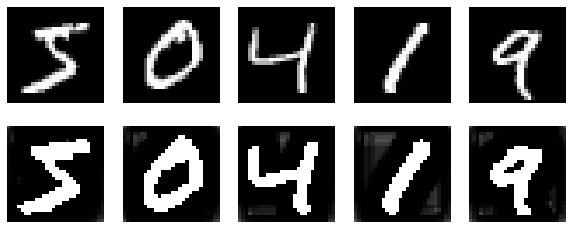

Epoch: 1/50 | Loss: 0.4848


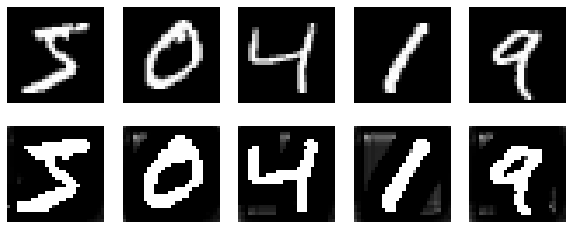

Epoch: 2/50 | Loss: 0.4768


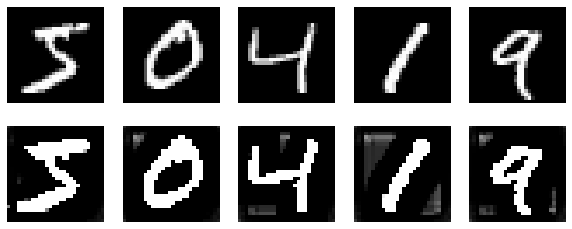

Epoch: 3/50 | Loss: 0.4261


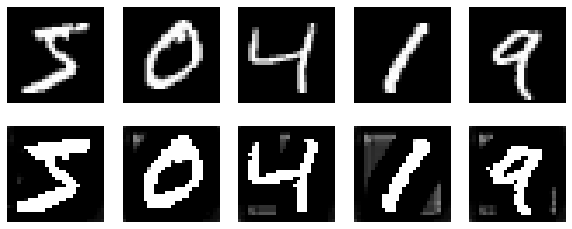

Epoch: 4/50 | Loss: 0.4401


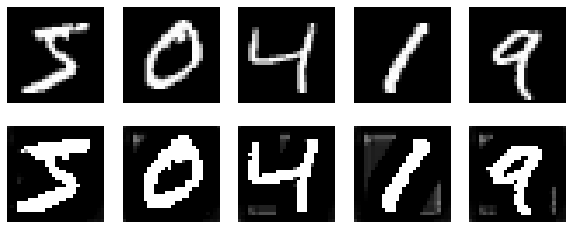

Epoch: 5/50 | Loss: 0.4400


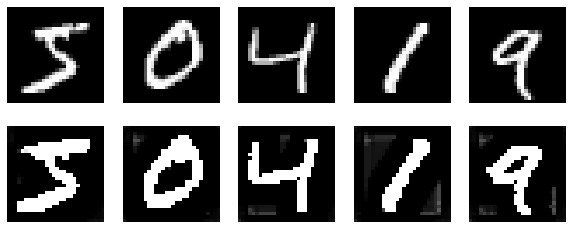

Epoch: 6/50 | Loss: 0.4264


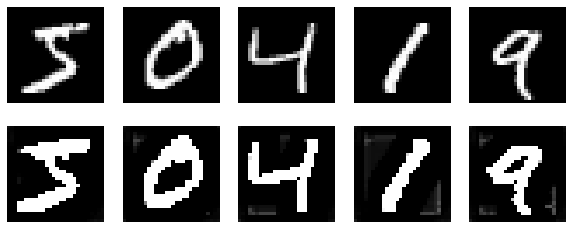

Epoch: 7/50 | Loss: 0.4380


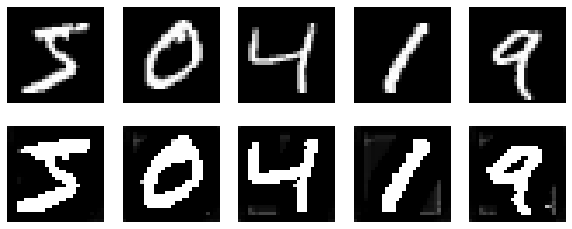

Epoch: 8/50 | Loss: 0.4749


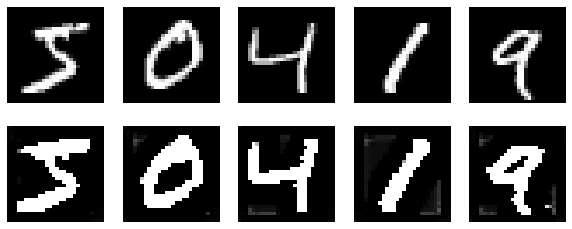

Epoch: 9/50 | Loss: 0.4797


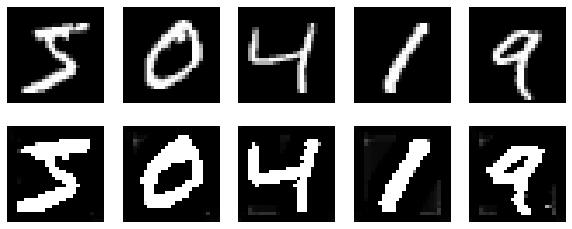

Epoch: 10/50 | Loss: 0.4519


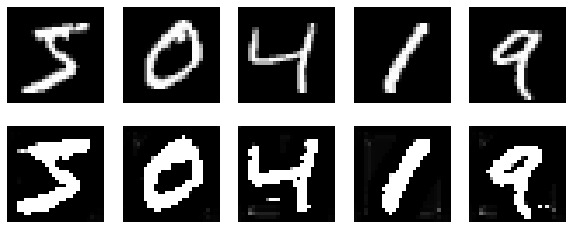

Epoch: 11/50 | Loss: 0.4716


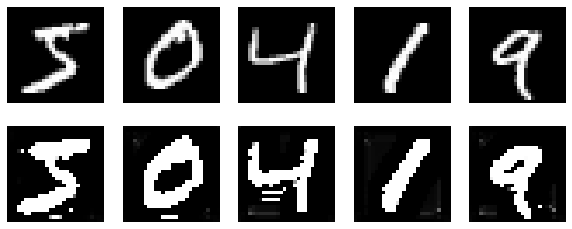

Epoch: 12/50 | Loss: 0.4848


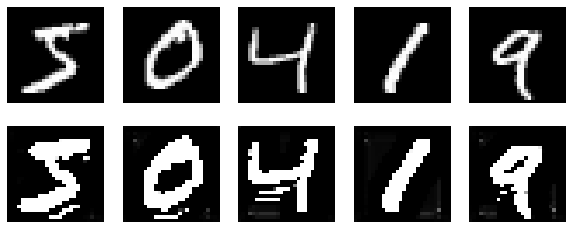

Epoch: 13/50 | Loss: 0.4798


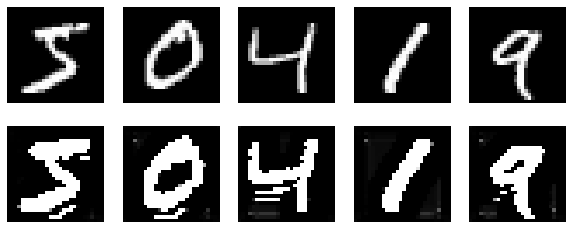

Epoch: 14/50 | Loss: 0.4177


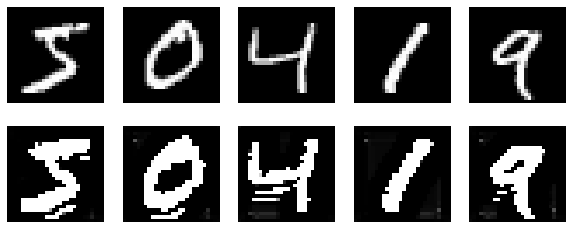

Epoch: 15/50 | Loss: 0.4980


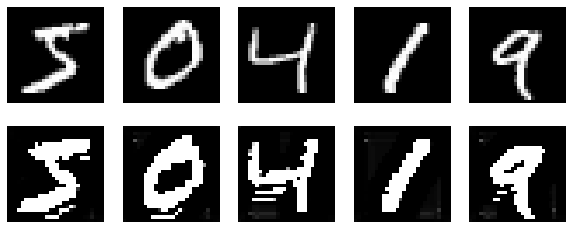

Epoch: 16/50 | Loss: 0.4847


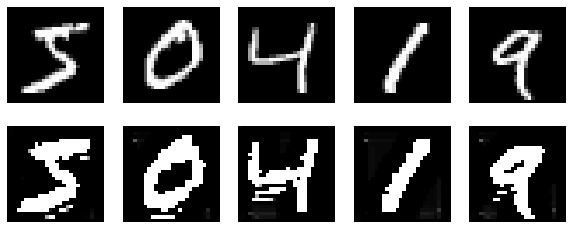

Epoch: 17/50 | Loss: 0.4751


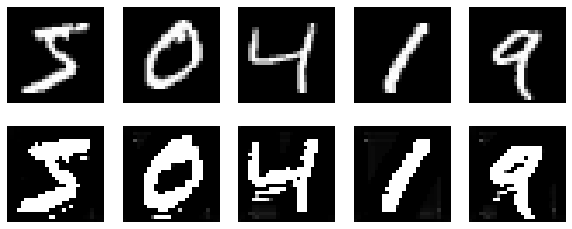

Epoch: 18/50 | Loss: 0.5017


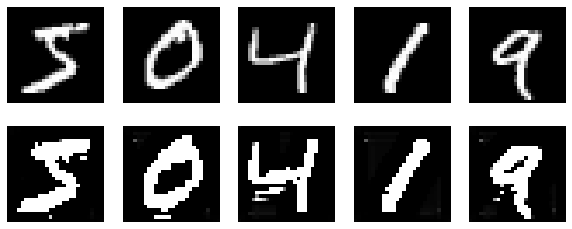

Epoch: 19/50 | Loss: 0.4936


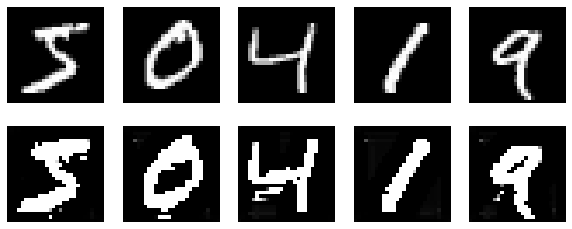

Epoch: 20/50 | Loss: 0.4774


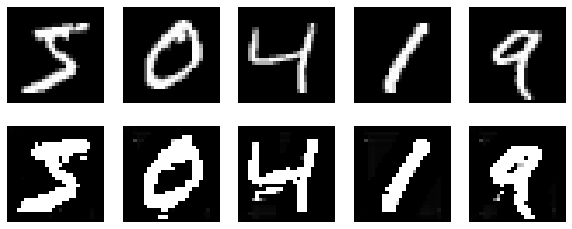

Epoch: 21/50 | Loss: 0.4707


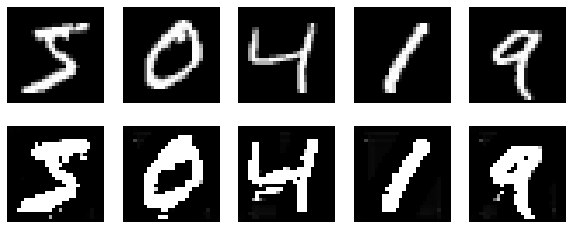

Epoch: 22/50 | Loss: 0.4688


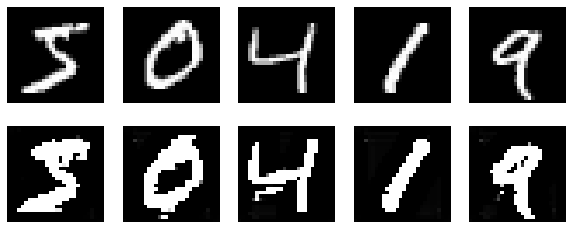

Epoch: 23/50 | Loss: 0.4847


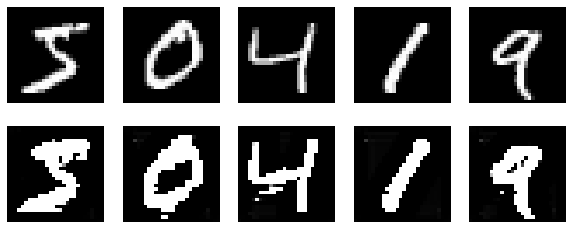

Epoch: 24/50 | Loss: 0.4489


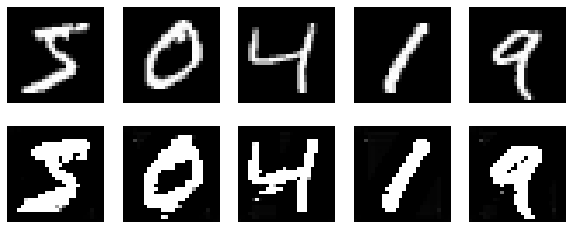

Epoch: 25/50 | Loss: 0.4580


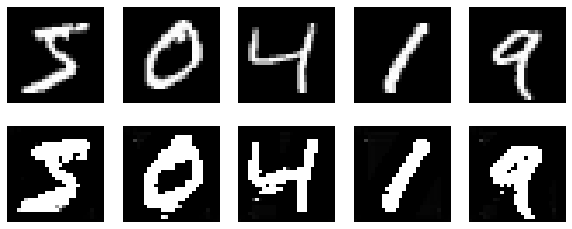

Epoch: 26/50 | Loss: 0.4767


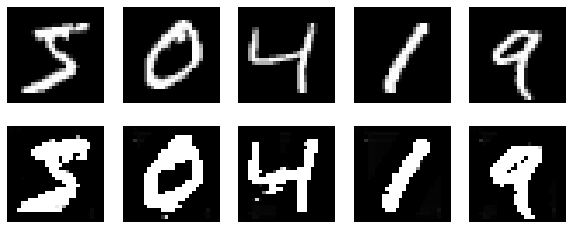

Epoch: 27/50 | Loss: 0.4907


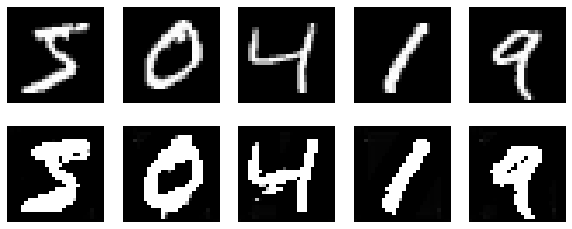

Epoch: 28/50 | Loss: 0.4472


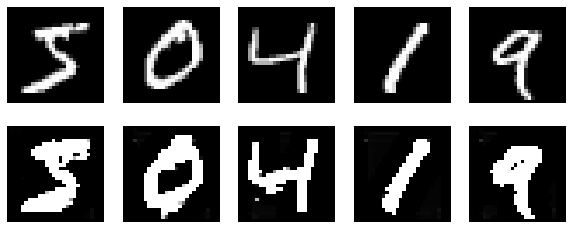

Epoch: 29/50 | Loss: 0.4773


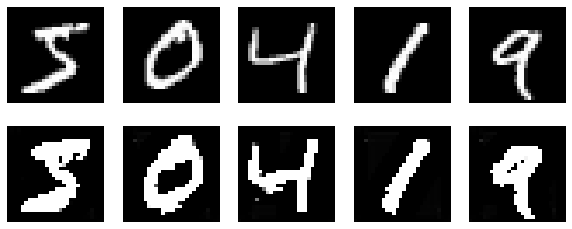

Epoch: 30/50 | Loss: 0.4922


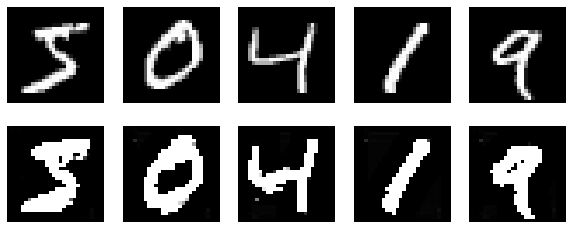

Epoch: 31/50 | Loss: 0.4520


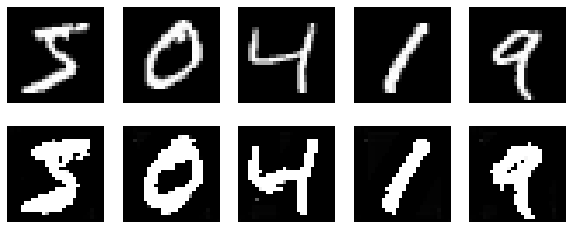

Epoch: 32/50 | Loss: 0.4882


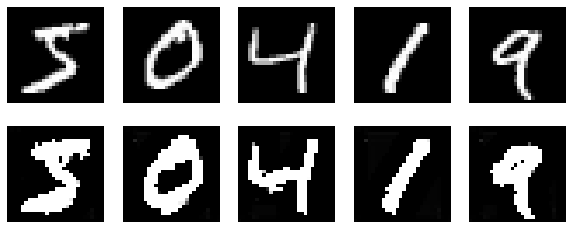

Epoch: 33/50 | Loss: 0.5039


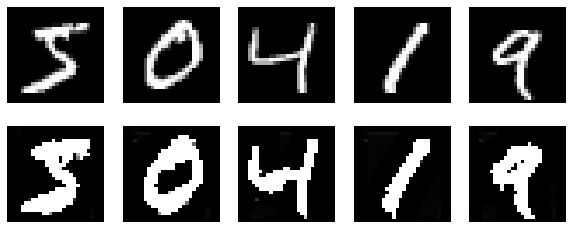

Epoch: 34/50 | Loss: 0.4479


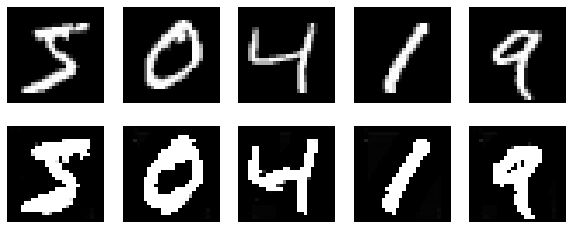

Epoch: 35/50 | Loss: 0.4978


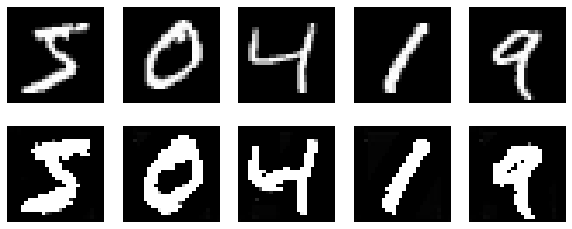

Epoch: 36/50 | Loss: 0.4851


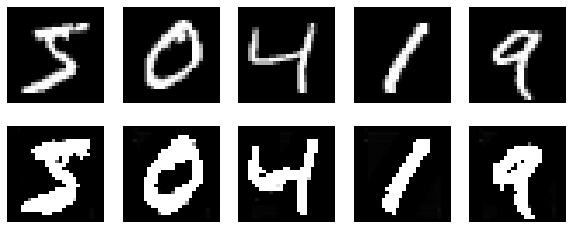

Epoch: 37/50 | Loss: 0.4815


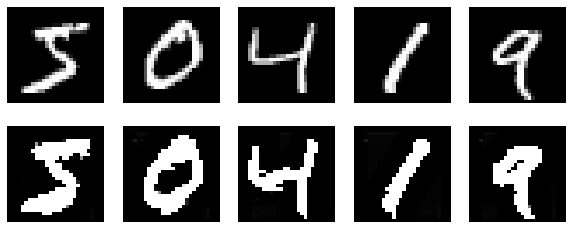

Epoch: 38/50 | Loss: 0.4715


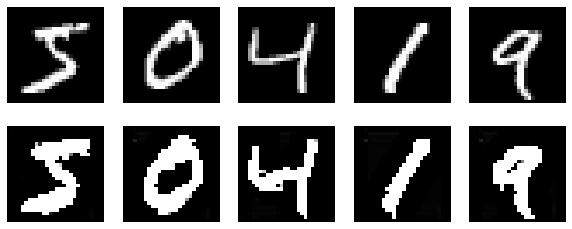

Epoch: 39/50 | Loss: 0.4334


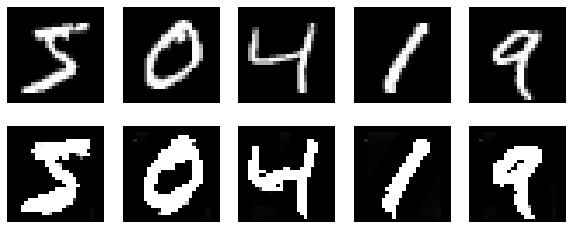

Epoch: 40/50 | Loss: 0.4662


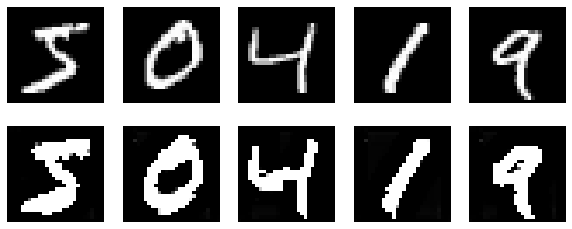

Epoch: 41/50 | Loss: 0.4855


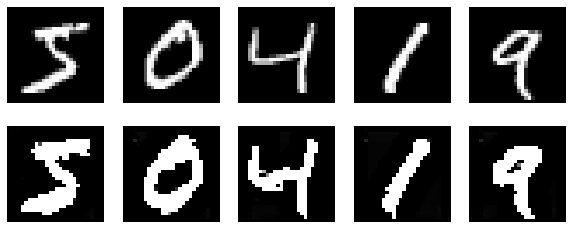

Epoch: 42/50 | Loss: 0.4331


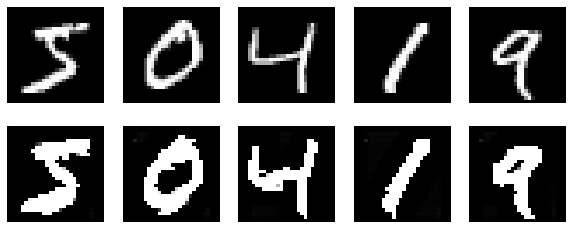

Epoch: 43/50 | Loss: 0.4437


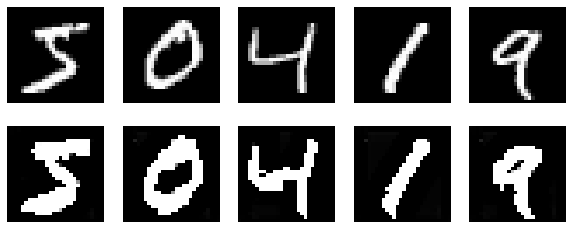

Epoch: 44/50 | Loss: 0.4516


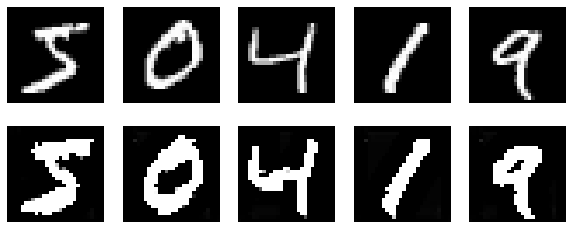

Epoch: 45/50 | Loss: 0.4459


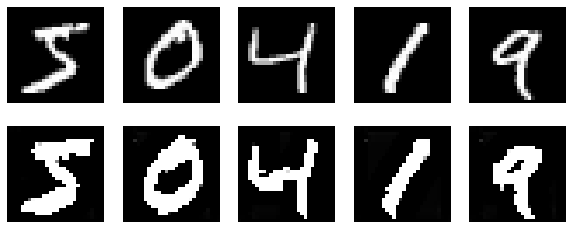

Epoch: 46/50 | Loss: 0.4980


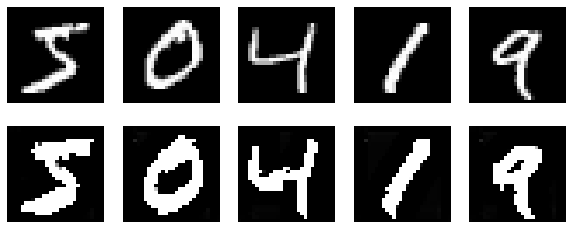

Epoch: 47/50 | Loss: 0.3967


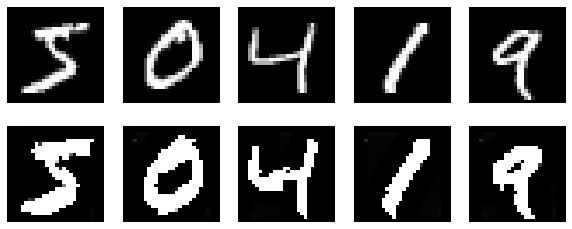

Epoch: 48/50 | Loss: 0.4994


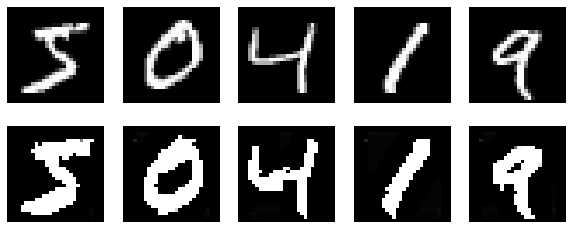

Epoch: 49/50 | Loss: 0.4332


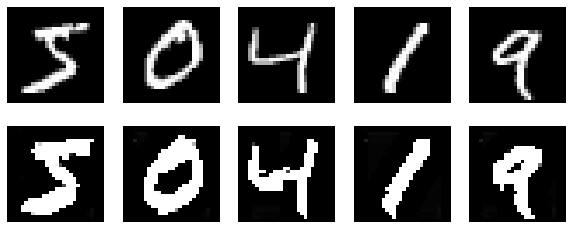

In [26]:
trainCAE(CAE, train_loader, view_data_cae, loss_func_cae, optimizer_cae)

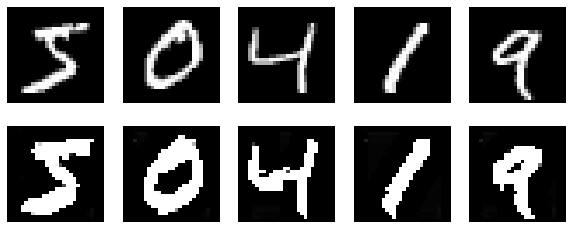

In [27]:
plot_img(CAE, view_data_cae)